# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [16]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from collections import deque
%matplotlib inline

## Functions

In [17]:
import math
import sys

# from the first exercise (I got Docker set up for that one before this project)
def normalized(image):
    
    copy = np.copy(image)
    
    r_lower = 100
    r_upper = 150
    
    g_lower = 100
    g_upper = 150
    
    b_lower = 100
    b_upper = 150
    
    rgb_thresholds = [r_lower, r_upper, g_lower, g_upper, b_lower, b_upper]
    
    # Identify pixels below the threshold
    # these are bit-wise operations, so '&' character, not 'and'
    
    #some explaining - instead of eliminating all below a given threshold, I eliminate all within a range.
    #this was meant to get rid of some of the gray pixels and improve performance on the challenge.mp4.
    #it doesn't work, but I like the idea enough that I'm leaving it here.
    
    #I eliminate all within a given region (conservatively eliminating all within a region of 100, 100, 100 to 
    #150, 150, 150). This means the gray in the road is blacked out, with the aim of reducing noise (e.g. cracks
    #in road being picked up as lines)
    
    thresholds = (((image[:,:,0] > rgb_thresholds[0]) & (image[:,:,0] < rgb_thresholds[1] )) \
            & \
            ((image[:,:,1] > rgb_thresholds[2]) & (image[:,:,1] < rgb_thresholds[3] )) \
            & \
            ((image[:,:,2] > rgb_thresholds[4]) & (image[:,:,2] < rgb_thresholds[5] )))
    
    copy[thresholds] = [0,0,0]
    
    return copy

def grayscale(img):
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):

    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):

    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image
        
default_left = -0.7 #range of about -0.6 to -0.8
default_right = 0.7 #likewise, but positive

previous_frames_left = deque([], 5)
previous_frames_right = deque([], 5)

def within_tolerance(average, current):
    
    return abs(average - current) < 0.1

#long function - sorry! I explain in the write-up

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    
    ymin = img.shape[0]
    ymax = img.shape[0] / 2 + 60 #trying to keep code independent of the size of the image
    
    right_points = []
    left_points = []
    
    left_slope_avg = 0
    right_slope_avg = 0
    
    left_b_avg = 0
    right_b_avg = 0
    
    count = 0
    
    try:
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope = (y2 - y1) / (x2 - x1)

                #right lane
                if((slope > 0.1 and right_slope_avg == 0) or (slope > 0.1 and within_tolerance(default_right, slope))):
                    if right_slope_avg == 0:
                        right_slope_avg = slope
                    right_points.append((x1,y1))
                    right_points.append((x2,y2))
                #left lane
                elif((slope < -0.1 and left_slope_avg == 0) or (slope > 0.1 and within_tolerance(default_left, slope))):
                    if left_slope_avg == 0:
                        left_slope_avg = slope

                    left_points.append((x1,y1))
                    left_points.append((x2,y2))
                else:
                    continue
                
        [left_vx,left_vy,left_x,left_y] = cv2.fitLine(np.array(left_points, dtype=np.int32), cv2.DIST_L2,0,0.01,0.01)
        [right_vx,right_vy,right_x,right_y] = cv2.fitLine(np.array(right_points, dtype=np.int32), cv2.DIST_L2,0,0.01,0.01)
    
    except (cv2.error, TypeError): 
        #if all fails, then don't draw anything for this frame (hopefully a rare occurrence)
        if(len(previous_frames_left) == 0 and left_slope_avg == 0 \
           and len(previous_frames_right) == 0 and right_slope_avg == 0):
            return #fat chance of doing anything if this happens
                
        #we don't accumulate the intercept (weirdly that reduced accuracy, no idea why)
        #instead we'll rely on what happened before, with maybe some input from now (the slope if we have it)
        
        if(len(previous_frames_left) > 0 and left_slope_avg != 0):
            left_line = np.sum(previous_frames_left, -1) / len(previous_frames_left)
            left_slope = (left_line[0] + left_slope_avg) / (len(previous_frames_left) + 1)
            left_b = left_line[1]
        elif(len(previous_frames_left) > 0):
            left_line = np.sum(previous_frames_left, -1) / len(previous_frames_left)
            left_slope = left_line[0] / len(previous_frames_left)
            left_b = left_line[1]
        else:
            return 
        
        if(len(previous_frames_right) > 0 and right_slope_avg != 0):
            right_line = np.sum(previous_frames_right, -1) / len(previous_frames_right)
            right_slope = (right_line[0] + right_slope_avg) / (len(previous_frames_right) + 1)
            right_b = right_line[1]
        elif(len(previous_frames_right) > 0):
            right_line = np.sum(previous_frames_right, -1) / len(previous_frames_right)
            right_slope = right_line[0] / len(previous_frames_right)
            right_b = right_line[1]
        else:
            return
        
        construct_lines(left_slope, left_b, right_slope, right_b, ymin, ymax, img, color, thickness)
    else:
        left_slope = left_vy / left_vx
        left_b = left_y - left_slope * left_x

        right_slope = right_vy / right_vx
        right_b = right_y - right_slope * right_x
        
        construct_lines(left_slope, left_b, right_slope, right_b, ymin, ymax, img, color, thickness)
        
def construct_lines(left_slope, left_b, right_slope, right_b, ymin, ymax, img, color, thickness):
    previous_frames_left.append([left_slope, left_b])
    left_line = np.mean(previous_frames_left, axis=0)
    left_slope = left_line[0]
    left_b = left_line[1]

    previous_frames_right.append((right_slope, right_b))
    right_line = np.mean(previous_frames_right, axis=0)
    right_slope = right_line[0]
    right_b = right_line[1]

    #solve for x
    left_x_min = int((ymin - left_b) / left_slope)
    left_x_max = int((ymax - left_b) / left_slope)
    
    right_x_min = int((ymin - right_b) / right_slope)
    right_x_max = int((ymax - right_b) / right_slope)

    cv2.line(img, (left_x_min,ymin), (left_x_max,int(ymax)), [255,0,0], thickness)
    cv2.line(img, (right_x_min,ymin), (right_x_max,int(ymax)), [255,0,0], thickness)

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines)
    
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [41]:
# several methods, to simplify debugging and switching between various outputs

def process_image(image):
    hou = process_hough(image)
    result = weighted_img(image, hou, 0.8, 1, 0)
    return result

def process_hough(image):
    mask = process_mask(image)
    hou = hough_lines(mask, 2, np.pi/180, 20, 10, 20)
    return hou

def process_mask(image):
    #norm = normalized(image)
    gray = grayscale(image)
    gaus = gaussian_blur(gray, 5)
    can = canny(gaus, 50, 150)
    
    shape = image.shape
    vertices = np.array([[(160,shape[0]),(420, 340), (640, 340), (900,shape[0])]], dtype=np.int32)
    return region_of_interest(can, vertices)

# The challenge video annoyed me, so I optimised the functions for it. They work much better (albeit not perfect).
# However, they are quite extreme, the mask is very much angled to the right and the canny function is tweaked too.

def process_image_challenge(image):
    hou = process_hough_challenge(image)
    result = weighted_img(image, hou, 0.8, 1, 0)
    return result

def process_hough_challenge(image):
    mask = process_mask_challenge(image)
    hou = hough_lines(mask, 2, np.pi/180, 20, 10, 20)
    return hou

def process_mask_challenge(image):
    #norm = normalized(image)
    gray = grayscale(image)
    gaus = gaussian_blur(gray, 5)
    can = canny(gaus, 70, 150)
    
    shape = image.shape
    vertices = np.array([[(160,shape[0]),(550, 340), (640, 340), (shape[1],shape[0])]], dtype=np.int32)
    return region_of_interest(can, vertices)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

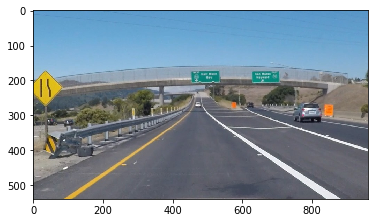

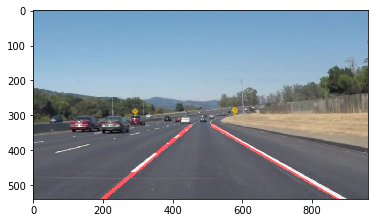

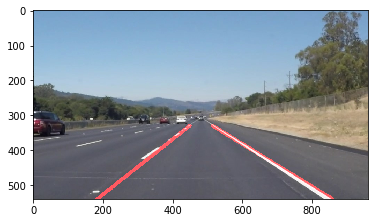

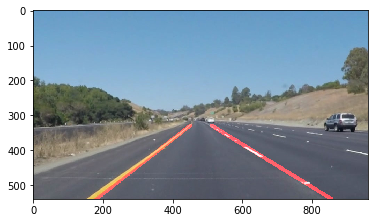

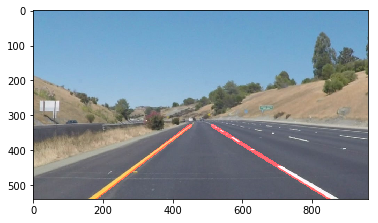

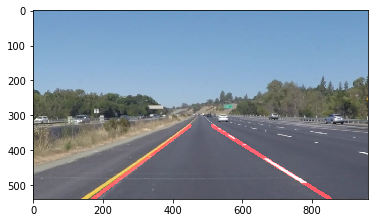

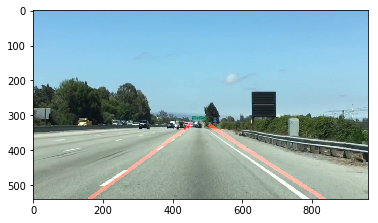

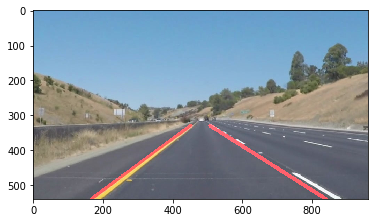

In [19]:
import glob

images = glob.glob('../images/*.jpg')

#the first image nothing shows (the normalising method works though, but then worse performance on the other images).
#otherwise a pretty solid performance! 
for image in images:
    image = mpimg.imread(image)
    result = process_image(image)
    
    plt.figure()
    plt.imshow(result)
    plt.show()
    
    #plt.imsave(result)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
yellow_output = '../videos/solidYellowLeft_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("../videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../videos/solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video ../videos/solidYellowLeft_output.mp4
[MoviePy] Writing video ../videos/solidYellowLeft_output.mp4


100%|█████████▉| 681/682 [01:32<00:00,  6.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../videos/solidYellowLeft_output.mp4 

CPU times: user 30.2 s, sys: 3.26 s, total: 33.5 s
Wall time: 1min 36s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

In [23]:
yellow_output = '../videos/solidYellowLeft_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('../videos/solidYellowLeft.mp4').subclip(0, 1)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video ../videos/solidYellowLeft_output.mp4
[MoviePy] Writing video ../videos/solidYellowLeft_output.mp4


 96%|█████████▌| 25/26 [00:02<00:00, 10.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../videos/solidYellowLeft_output.mp4 

CPU times: user 1.3 s, sys: 340 ms, total: 1.64 s
Wall time: 5.14 s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [42]:
challenge_output = '../videos/challenge_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('../videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_challenge)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video ../videos/challenge_output.mp4
[MoviePy] Writing video ../videos/challenge_output.mp4


100%|██████████| 251/251 [00:22<00:00, 11.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../videos/challenge_output.mp4 

CPU times: user 6.83 s, sys: 930 ms, total: 7.76 s
Wall time: 25.7 s


In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
# Thanks for reading! :D